# Phase 2A: Transformer Component for Temporal Pattern Recognition
## Scalable Threat Assessment ML Framework for CI/CD DevSecOps Pipelines

**Research Project**: Hybrid Transformer-GNN Ensemble Architecture  
**Component**: Temporal Pattern Analysis using Transformer Architecture  
**Dataset**: CICIDS-2017 (CTGAN-augmented)  
**Environment**: Google Colab - Python 3.12, PyTorch 2.8+, CUDA 12.6, Tesla T4

---

### Overview
This notebook implements the Transformer component for processing sequential security events from CI/CD pipelines. The architecture uses multi-head self-attention mechanisms to detect temporal attack patterns across extensive event sequences (up to 10,000 tokens).

**Key Features**:
- Multi-head self-attention for temporal dependency learning
- Positional encoding for sequence order preservation
- Memory-efficient batch processing for large datasets
- GPU-accelerated training with automatic mixed precision
- Comprehensive evaluation metrics (Accuracy, Precision, Recall, F1, False Positive Rate)
- Model checkpointing and early stopping

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Environment Setup and Dependencies

In [2]:
# Install/upgrade required packages for current Colab environment
!pip install -q --upgrade torch torchvision torchaudio
!pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [3]:
# Import core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import pandas as pd
import numpy as np
import pickle
import math
import os
import json
from datetime import datetime
from pathlib import Path
from tqdm.auto import tqdm

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# Verify environment
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

PyTorch Version: 2.9.1+cu128
CUDA Available: True
CUDA Version: 12.8
GPU Device: Tesla T4
GPU Memory: 15.83 GB

Using device: cuda


In [5]:
%cd /content/drive/MyDrive/mythesis/akhila/CICIDS2017/

/content/drive/MyDrive/mythesis/akhila/CICIDS2017


## 2. Configuration and Hyperparameters

In [6]:
# Configuration dictionary
CONFIG = {
    # Data paths
    'data_dir': '/content/drive/MyDrive/mythesis/akhila/CICIDS2017/processed',  # Update this path
    'train_features': 'X_train_augmented_cicids2017.csv',
    'train_labels': 'y_train_augmented_cicids2017.csv',
    'val_features': 'X_val_cicids2017.csv',
    'val_labels': 'y_val_cicids2017.csv',
    'test_features': 'X_test_cicids2017.csv',
    'test_labels': 'y_test_cicids2017.csv',
    'scaler': 'scaler_cicids2017.pkl',
    'label_encoder': 'label_encoder_cicids2017.pkl',

    # Model architecture
    'sequence_length': 128,  # Number of time steps per sequence
    'd_model': 256,  # Transformer embedding dimension
    'nhead': 8,  # Number of attention heads
    'num_encoder_layers': 6,  # Number of transformer encoder layers
    'd_feedforward': 1024,  # Feedforward network dimension
    'dropout': 0.1,  # Dropout rate
    'activation': 'gelu',  # Activation function

    # Training parameters
    'batch_size': 256,  # Adjust based on GPU memory
    'learning_rate': 0.0001,
    'weight_decay': 0.01,
    'num_epochs': 50,
    'warmup_steps': 1000,
    'gradient_clip': 1.0,
    'early_stopping_patience': 7,

    # Data loading
    'num_workers': 2,
    'pin_memory': True,
    'prefetch_factor': 2,

    # Mixed precision training
    'use_amp': True,  # Automatic Mixed Precision

    # Checkpointing
    'checkpoint_dir': './checkpoints',
    'save_best_only': True,

    # Evaluation
    'log_interval': 100,  # Log every N batches
    'eval_interval': 1,  # Evaluate every N epochs
}

# Create checkpoint directory
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

# Print configuration
print("Configuration:")
print(json.dumps(CONFIG, indent=2))

Configuration:
{
  "data_dir": "/content/drive/MyDrive/mythesis/akhila/CICIDS2017/processed",
  "train_features": "X_train_augmented_cicids2017.csv",
  "train_labels": "y_train_augmented_cicids2017.csv",
  "val_features": "X_val_cicids2017.csv",
  "val_labels": "y_val_cicids2017.csv",
  "test_features": "X_test_cicids2017.csv",
  "test_labels": "y_test_cicids2017.csv",
  "scaler": "scaler_cicids2017.pkl",
  "label_encoder": "label_encoder_cicids2017.pkl",
  "sequence_length": 128,
  "d_model": 256,
  "nhead": 8,
  "num_encoder_layers": 6,
  "d_feedforward": 1024,
  "dropout": 0.1,
  "activation": "gelu",
  "batch_size": 256,
  "learning_rate": 0.0001,
  "weight_decay": 0.01,
  "num_epochs": 50,
  "warmup_steps": 1000,
  "gradient_clip": 1.0,
  "early_stopping_patience": 7,
  "num_workers": 2,
  "pin_memory": true,
  "prefetch_factor": 2,
  "use_amp": true,
  "checkpoint_dir": "./checkpoints",
  "save_best_only": true,
  "log_interval": 100,
  "eval_interval": 1
}


## 3. Data Loading and Preprocessing

In [7]:
class SecurityDataset(Dataset):
    """
    Custom Dataset for CICIDS-2017 security event data.
    Handles memory-efficient loading and sequence creation for temporal analysis.
    """

    def __init__(self, features_path, labels_path, sequence_length=128,
                 chunk_size=50000, max_samples=None):
        """
        Args:
            features_path: Path to features CSV file
            labels_path: Path to labels CSV file
            sequence_length: Number of time steps per sequence
            chunk_size: Number of rows to load at once (memory management)
            max_samples: Maximum number of samples to load (for testing)
        """
        self.sequence_length = sequence_length
        print(f"Loading data from {features_path}...")

        # Load data in chunks for memory efficiency
        chunks = []
        total_rows = 0

        for chunk in tqdm(pd.read_csv(features_path, chunksize=chunk_size),
                         desc="Loading features"):
            chunks.append(chunk)
            total_rows += len(chunk)
            if max_samples and total_rows >= max_samples:
                chunks[-1] = chunks[-1].iloc[:max_samples - (total_rows - len(chunk))]
                break

        self.features = pd.concat(chunks, ignore_index=True)

        # Load labels
        if max_samples:
            self.labels = pd.read_csv(labels_path, nrows=max_samples)
        else:
            self.labels = pd.read_csv(labels_path)

        # Convert to numpy for faster access
        self.features = self.features.values.astype(np.float32)
        self.labels = self.labels.values.flatten().astype(np.int64)

        # Calculate number of sequences
        self.num_samples = len(self.features)
        self.num_sequences = self.num_samples - sequence_length + 1

        print(f"Loaded {self.num_samples} samples, {self.num_sequences} sequences")
        print(f"Feature shape: {self.features.shape}")
        print(f"Labels shape: {self.labels.shape}")
        print(f"Unique classes: {len(np.unique(self.labels))}")

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        """
        Returns a sequence of features and the corresponding label.
        For threat detection, we use the label of the last event in the sequence.
        """
        # Extract sequence
        sequence = self.features[idx:idx + self.sequence_length]

        # Use label of the last event in sequence (target for prediction)
        label = self.labels[idx + self.sequence_length - 1]

        return torch.from_numpy(sequence), torch.tensor(label, dtype=torch.long)

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle
import os

print("Loading label encoder (with compatibility fix)...")

try:
    # Try original pickle file first
    with open(os.path.join(CONFIG['data_dir'], CONFIG['label_encoder']), 'rb') as f:
        label_encoder = pickle.load(f)
    print("✓ Loaded original label encoder")

except Exception as e:
    print(f"⚠ Pickle incompatibility detected: {e.__class__.__name__}")
    print("  Recreating label encoder from training data...")

    # Read training labels to get all unique classes by iterating through chunks
    print("  Reading training labels to find all unique classes...")
    all_unique_labels = set()
    # Assuming labels are in the first column named 'Label_Encoded'
    for chunk in tqdm(pd.read_csv(
        os.path.join(CONFIG['data_dir'], CONFIG['train_labels']),
        chunksize=100000, # Process in chunks to save memory
        usecols=['Label_Encoded']
    ), desc="Collecting unique labels"):
        all_unique_labels.update(chunk['Label_Encoded'].unique())

    # Get unique classes (sorted for consistency)
    unique_classes = np.sort(list(all_unique_labels))
    print(f"  Found {len(unique_classes)} unique classes")

    # Create new label encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(unique_classes)

    # Save new compatible version
    new_path = os.path.join(CONFIG['checkpoint_dir'], 'label_encoder_fixed.pkl')
    os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
    with open(new_path, 'wb') as f:
        pickle.dump(label_encoder, f)

    print(f"✓ Label encoder recreated and saved to: {new_path}")

# Get number of classes and class names
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f"\nLabel Encoder Ready:")
print(f"  Number of classes: {num_classes}")
print(f"  Class names: {list(class_names)}")

# Store in config
CONFIG['num_classes'] = num_classes

# Quick verification
print("\nVerification (encoding first 3 classes):")
for i in range(min(3, num_classes)):
    test_class = class_names[i]
    encoded = label_encoder.transform([test_class])[0]
    decoded = label_encoder.inverse_transform([encoded])[0]
    print(f"  '{test_class}' → {encoded} → '{decoded}' ✓")

print("\n✓ Ready to proceed with dataset creation!")

Loading label encoder (with compatibility fix)...
⚠ Pickle incompatibility detected: UnpicklingError
  Recreating label encoder from training data...
  Reading training labels to find all unique classes...


  Found 15 unique classes
✓ Label encoder recreated and saved to: ./checkpoints/label_encoder_fixed.pkl

Label Encoder Ready:
  Number of classes: 15
  Class names: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)]

Verification (encoding first 3 classes):
  '0' → 0 → '0' ✓
  '1' → 1 → '1' ✓
  '2' → 2 → '2' ✓

✓ Ready to proceed with dataset creation!


In [9]:
# Create datasets
# For initial testing, you can use max_samples to load a subset
print("Creating training dataset...")
train_dataset = SecurityDataset(
    os.path.join(CONFIG['data_dir'], CONFIG['train_features']),
    os.path.join(CONFIG['data_dir'], CONFIG['train_labels']),
    sequence_length=CONFIG['sequence_length'],
    # max_samples=100000  # Uncomment for faster testing
)

print("\nCreating validation dataset...")
val_dataset = SecurityDataset(
    os.path.join(CONFIG['data_dir'], CONFIG['val_features']),
    os.path.join(CONFIG['data_dir'], CONFIG['val_labels']),
    sequence_length=CONFIG['sequence_length']
)

print("\nCreating test dataset...")
test_dataset = SecurityDataset(
    os.path.join(CONFIG['data_dir'], CONFIG['test_features']),
    os.path.join(CONFIG['data_dir'], CONFIG['test_labels']),
    sequence_length=CONFIG['sequence_length']
)

Creating training dataset...
Loading data from /content/drive/MyDrive/mythesis/akhila/CICIDS2017/processed/X_train_augmented_cicids2017.csv...


Loading features: 0it [00:00, ?it/s]

Loaded 11740305 samples, 11740178 sequences
Feature shape: (11740305, 78)
Labels shape: (11740305,)
Unique classes: 15

Creating validation dataset...
Loading data from /content/drive/MyDrive/mythesis/akhila/CICIDS2017/processed/X_val_cicids2017.csv...


Loading features: 0it [00:00, ?it/s]

Loaded 378354 samples, 378227 sequences
Feature shape: (378354, 78)
Labels shape: (378354,)
Unique classes: 15

Creating test dataset...
Loading data from /content/drive/MyDrive/mythesis/akhila/CICIDS2017/processed/X_test_cicids2017.csv...


Loading features: 0it [00:00, ?it/s]

Loaded 378355 samples, 378228 sequences
Feature shape: (378355, 78)
Labels shape: (378355,)
Unique classes: 15


In [10]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory'],
    prefetch_factor=CONFIG['prefetch_factor']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory']
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory']
)

print(f"\nData loaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Data loaders created:
Train batches: 45861
Validation batches: 1478
Test batches: 1478


## 4. Transformer Model Architecture

In [11]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to input embeddings.
    Essential for transformers to understand sequence order.
    """

    def __init__(self, d_model, max_len=10000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (seq_len, batch_size, d_model)
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [12]:
class ThreatDetectionTransformer(nn.Module):
    """
    Transformer-based architecture for temporal threat pattern recognition.

    Architecture:
    1. Input projection: Maps features to d_model dimensions
    2. Positional encoding: Adds sequence position information
    3. Transformer encoder: Multi-head self-attention layers
    4. Global pooling: Aggregates sequence information
    5. Classification head: Maps to threat categories
    """

    def __init__(self, input_dim, d_model=256, nhead=8, num_encoder_layers=6,
                 d_feedforward=1024, dropout=0.1, num_classes=8, activation='gelu'):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model

        # Input projection layer
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.GELU() if activation == 'gelu' else nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=False,  # (seq_len, batch, features)
            norm_first=True  # Pre-LN architecture (more stable)
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers,
            norm=nn.LayerNorm(d_model)
        )

        # Global pooling (both max and average for richer representation)
        self.pooling_type = 'both'  # 'max', 'avg', or 'both'

        # Classification head
        classifier_input_dim = d_model * 2 if self.pooling_type == 'both' else d_model

        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.GELU() if activation == 'gelu' else nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.GELU() if activation == 'gelu' else nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights using Xavier/Kaiming initialization."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x, return_attention=False):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
            return_attention: If True, return attention weights

        Returns:
            logits: Classification logits of shape (batch_size, num_classes)
            attention_weights: (Optional) Attention weights from encoder
        """
        batch_size, seq_len, _ = x.shape

        # Project input to d_model dimensions
        x = self.input_projection(x)  # (batch, seq_len, d_model)

        # Transpose for transformer: (seq_len, batch, d_model)
        x = x.transpose(0, 1)

        # Add positional encoding
        x = self.pos_encoder(x)

        # Apply transformer encoder
        encoded = self.transformer_encoder(x)  # (seq_len, batch, d_model)

        # Transpose back: (batch, seq_len, d_model)
        encoded = encoded.transpose(0, 1)

        # Global pooling
        if self.pooling_type == 'max':
            pooled = torch.max(encoded, dim=1)[0]
        elif self.pooling_type == 'avg':
            pooled = torch.mean(encoded, dim=1)
        else:  # 'both'
            max_pooled = torch.max(encoded, dim=1)[0]
            avg_pooled = torch.mean(encoded, dim=1)
            pooled = torch.cat([max_pooled, avg_pooled], dim=1)

        # Classification
        logits = self.classifier(pooled)

        if return_attention:
            # Note: Getting attention weights requires modifying TransformerEncoder
            # This is a placeholder for future implementation
            return logits, None

        return logits

    def get_num_params(self):
        """Return the number of trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [17]:
# Get input dimension from dataset
sample_batch, _ = next(iter(train_loader))
input_dim = sample_batch.shape[2]  # (batch, seq_len, input_dim)

print(f"Input dimension: {input_dim}")

# Initialize model
model = ThreatDetectionTransformer(
    input_dim=input_dim,
    d_model=CONFIG['d_model'],
    nhead=CONFIG['nhead'],
    num_encoder_layers=CONFIG['num_encoder_layers'],
    d_feedforward=CONFIG['d_feedforward'],
    dropout=CONFIG['dropout'],
    num_classes=CONFIG['num_classes'],
    activation=CONFIG['activation']
).to(device)

print(f"\nModel initialized with {model.get_num_params():,} trainable parameters")

# Test forward pass
with torch.no_grad():
    test_output = model(sample_batch[:2].to(device))
    print(f"Test output shape: {test_output.shape}")
    print(f"Expected shape: (batch_size={2}, num_classes={CONFIG['num_classes']})")

Input dimension: 78

Model initialized with 4,926,735 trainable parameters
Test output shape: torch.Size([2, 15])
Expected shape: (batch_size=2, num_classes=15)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## 5. Training Setup

In [18]:
class WarmupCosineSchedule:
    """
    Learning rate scheduler with linear warmup and cosine annealing.
    Helps stabilize training in early epochs.
    """

    def __init__(self, optimizer, warmup_steps, total_steps, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr
        self.base_lr = optimizer.param_groups[0]['lr']
        self.current_step = 0

    def step(self):
        self.current_step += 1

        if self.current_step < self.warmup_steps:
            # Linear warmup
            lr = self.base_lr * self.current_step / self.warmup_steps
        else:
            # Cosine annealing
            progress = (self.current_step - self.warmup_steps) / \
                      (self.total_steps - self.warmup_steps)
            lr = self.min_lr + (self.base_lr - self.min_lr) * \
                 0.5 * (1 + math.cos(math.pi * progress))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

In [19]:
# Calculate class weights for imbalanced data
def calculate_class_weights(labels, num_classes):
    """Calculate class weights inversely proportional to class frequencies."""
    class_counts = np.bincount(labels, minlength=num_classes)
    total_samples = len(labels)
    class_weights = total_samples / (num_classes * class_counts)
    return torch.FloatTensor(class_weights)

# Get class weights from training data
train_labels = train_dataset.labels[CONFIG['sequence_length']-1:]
class_weights = calculate_class_weights(train_labels, CONFIG['num_classes']).to(device)

print("Class weights:")
for i, weight in enumerate(class_weights):
    print(f"  Class {i} ({class_names[i]}): {weight:.4f}")

Class weights:
  Class 0 (0): 0.2841
  Class 1 (1): 1.4461
  Class 2 (2): 0.6030
  Class 3 (3): 1.2249
  Class 4 (4): 0.5285
  Class 5 (5): 1.1149
  Class 6 (6): 1.0069
  Class 7 (7): 1.0385
  Class 8 (8): 6.6635
  Class 9 (9): 4.2947
  Class 10 (10): 0.9498
  Class 11 (11): 1.3128
  Class 12 (12): 1.3783
  Class 13 (13): 5.2364
  Class 14 (14): 2.1974


In [20]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    betas=(0.9, 0.999),
    eps=1e-8
)

# Learning rate scheduler
total_steps = len(train_loader) * CONFIG['num_epochs']
scheduler = WarmupCosineSchedule(
    optimizer,
    warmup_steps=CONFIG['warmup_steps'],
    total_steps=total_steps
)

# Gradient scaler for mixed precision training
scaler = GradScaler() if CONFIG['use_amp'] else None

print(f"Optimizer: AdamW")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Weight decay: {CONFIG['weight_decay']}")
print(f"Total training steps: {total_steps:,}")
print(f"Warmup steps: {CONFIG['warmup_steps']:,}")
print(f"Mixed precision training: {CONFIG['use_amp']}")

Optimizer: AdamW
Learning rate: 0.0001
Weight decay: 0.01
Total training steps: 2,293,050
Warmup steps: 1,000
Mixed precision training: True


/tmp/ipython-input-181752807.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if CONFIG['use_amp'] else None


## 6. Training Loop

In [21]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, scaler, device, epoch):
    """
    Train for one epoch.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")

    for batch_idx, (features, labels) in enumerate(progress_bar):
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision training
        if scaler is not None:
            with autocast():
                outputs = model(features)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
            optimizer.step()

        # Update learning rate
        current_lr = scheduler.step()

        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        total_loss += loss.item()

        # Update progress bar
        if (batch_idx + 1) % CONFIG['log_interval'] == 0:
            avg_loss = total_loss / (batch_idx + 1)
            accuracy = 100. * correct / total
            progress_bar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'acc': f'{accuracy:.2f}%',
                'lr': f'{current_lr:.2e}'
            })

    return total_loss / len(dataloader), 100. * correct / total

In [22]:
def evaluate(model, dataloader, criterion, device):
    """
    Evaluate the model on validation/test set.
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for features, labels in tqdm(dataloader, desc="Evaluating"):
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            probabilities = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Calculate metrics
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

    # Calculate false positive rate
    cm = confusion_matrix(all_labels, all_predictions)
    fp = cm.sum(axis=0) - np.diag(cm)
    tn = cm.sum() - (fp + cm.sum(axis=1) + np.diag(cm))
    fpr = np.mean(fp / (fp + tn + 1e-10))  # Average FPR across classes

    metrics = {
        'loss': total_loss / len(dataloader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities
    }

    return metrics

In [23]:
def save_checkpoint(model, optimizer, epoch, metrics, filepath, is_best=False):
    """
    Save model checkpoint.
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics,
        'config': CONFIG
    }

    torch.save(checkpoint, filepath)

    if is_best:
        best_path = os.path.join(CONFIG['checkpoint_dir'], 'best_model.pth')
        torch.save(checkpoint, best_path)
        print(f"  ✓ Best model saved to {best_path}")

In [24]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'val_fpr': [],
    'learning_rates': []
}

best_val_f1 = 0
patience_counter = 0

print("\n" + "="*80)
print("Starting Training")
print("="*80)

for epoch in range(1, CONFIG['num_epochs'] + 1):
    print(f"\nEpoch {epoch}/{CONFIG['num_epochs']}")
    print("-" * 80)

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, scaler, device, epoch
    )

    # Evaluate on validation set
    if epoch % CONFIG['eval_interval'] == 0:
        val_metrics = evaluate(model, val_loader, criterion, device)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'] * 100)
        history['val_f1'].append(val_metrics['f1'])
        history['val_fpr'].append(val_metrics['fpr'])

        # Print results
        print(f"\nResults:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']*100:.2f}%")
        print(f"  Val Precision: {val_metrics['precision']:.4f} | Val Recall: {val_metrics['recall']:.4f}")
        print(f"  Val F1: {val_metrics['f1']:.4f} | Val FPR: {val_metrics['fpr']:.4f}")

        # Save checkpoint
        is_best = val_metrics['f1'] > best_val_f1
        if is_best:
            best_val_f1 = val_metrics['f1']
            patience_counter = 0
        else:
            patience_counter += 1

        checkpoint_path = os.path.join(
            CONFIG['checkpoint_dir'],
            f"checkpoint_epoch_{epoch}.pth"
        )
        save_checkpoint(model, optimizer, epoch, val_metrics, checkpoint_path, is_best)

        # Early stopping
        if patience_counter >= CONFIG['early_stopping_patience']:
            print(f"\nEarly stopping triggered after {epoch} epochs")
            print(f"Best validation F1: {best_val_f1:.4f}")
            break

print("\n" + "="*80)
print("Training Complete!")
print("="*80)


Starting Training

Epoch 1/50
--------------------------------------------------------------------------------


Epoch 1:   0%|          | 0/45861 [00:01<?, ?it/s]

/tmp/ipython-input-785160709.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/1478 [00:00<?, ?it/s]


Results:
  Train Loss: 2.1454 | Train Acc: 37.03%
  Val Loss: 0.0985 | Val Acc: 97.44%
  Val Precision: 0.9773 | Val Recall: 0.9744
  Val F1: 0.9749 | Val FPR: 0.0003
  ✓ Best model saved to ./checkpoints/best_model.pth

Epoch 2/50
--------------------------------------------------------------------------------


Epoch 2:   0%|          | 0/45861 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160><function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():
             ^ ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Evaluating:   0%|          | 0/1478 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        if w.is_alive():self._shutdown_workers()
 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():
     ^ ^ ^ ^ ^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ 
   File "/usr/lib/pyth


Results:
  Train Loss: 2.0710 | Train Acc: 39.31%
  Val Loss: 0.0849 | Val Acc: 97.45%
  Val Precision: 0.9782 | Val Recall: 0.9745
  Val F1: 0.9752 | Val FPR: 0.0005
  ✓ Best model saved to ./checkpoints/best_model.pth

Epoch 3/50
--------------------------------------------------------------------------------


Epoch 3:   0%|          | 0/45861 [00:01<?, ?it/s]

/tmp/ipython-input-785160709.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-pac

Evaluating:   0%|          | 0/1478 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Results:
  Train Loss: 2.0465 | Train Acc: 40.03%
  Val Loss: 0.0765 | Val Acc: 97.24%
  Val Precision: 0.9759 | Val Recall: 0.9724
  Val F1: 0.9730 | Val FPR: 0.0015

Epoch 4/50
--------------------------------------------------------------------------------


Epoch 4:   0%|          | 0/45861 [00:01<?, ?it/s]

/tmp/ipython-input-785160709.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-pac

Evaluating:   0%|          | 0/1478 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Results:
  Train Loss: 2.0282 | Train Acc: 40.61%
  Val Loss: 0.0624 | Val Acc: 98.66%
  Val Precision: 0.9879 | Val Recall: 0.9866
  Val F1: 0.9866 | Val FPR: 0.0005
  ✓ Best model saved to ./checkpoints/best_model.pth

Epoch 5/50
--------------------------------------------------------------------------------


Epoch 5:   0%|          | 0/45861 [00:01<?, ?it/s]

/tmp/ipython-input-785160709.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-pac

Evaluating:   0%|          | 0/1478 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160><function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
   if w.is_alive(): 
       ^ ^ ^ ^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python


Results:
  Train Loss: 2.0088 | Train Acc: 41.20%
  Val Loss: 0.0494 | Val Acc: 98.95%
  Val Precision: 0.9897 | Val Recall: 0.9895
  Val F1: 0.9893 | Val FPR: 0.0004
  ✓ Best model saved to ./checkpoints/best_model.pth

Epoch 6/50
--------------------------------------------------------------------------------


Epoch 6:   0%|          | 0/45861 [00:00<?, ?it/s]

/tmp/ipython-input-785160709.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-pac

KeyboardInterrupt: 

## 7. Training Visualization

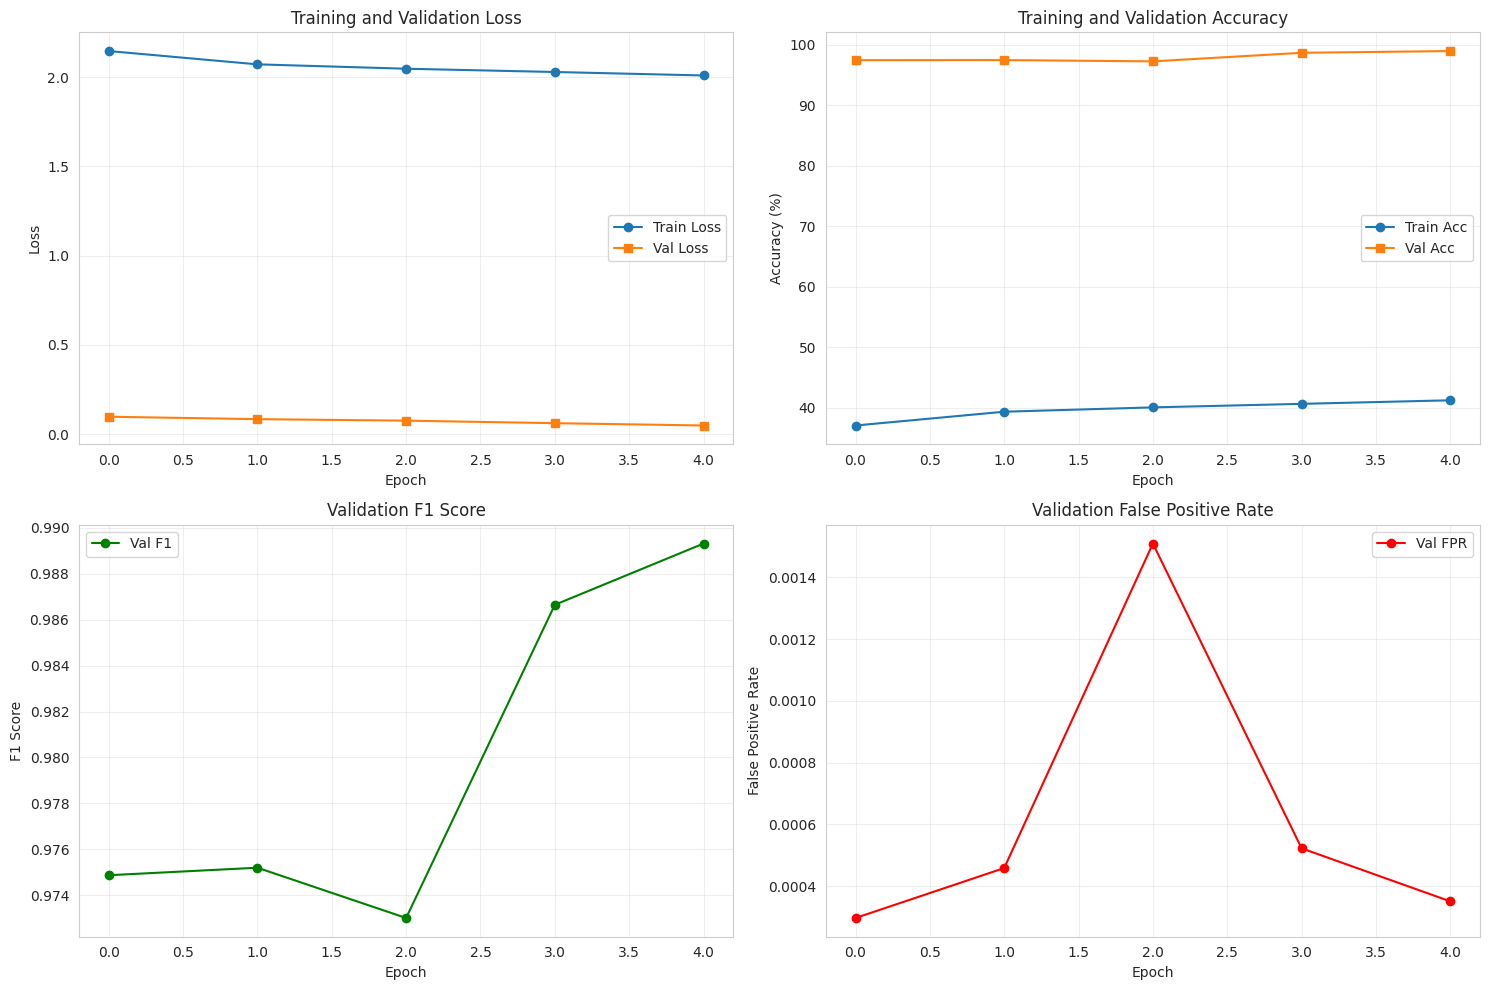

In [25]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score
axes[1, 0].plot(history['val_f1'], label='Val F1', marker='o', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Validation F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# False Positive Rate
axes[1, 1].plot(history['val_fpr'], label='Val FPR', marker='o', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('False Positive Rate')
axes[1, 1].set_title('Validation False Positive Rate')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['checkpoint_dir'], 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

## 8. Final Evaluation on Test Set

In [31]:
# Load best model
best_checkpoint = torch.load(os.path.join(CONFIG['checkpoint_dir'], 'best_model.pth'), weights_only=False)
model.load_state_dict(best_checkpoint['model_state_dict'])

print(f"Loaded best model from epoch {best_checkpoint['epoch']}")
print(f"Best validation F1: {best_checkpoint['metrics']['f1']:.4f}")

Loaded best model from epoch 5
Best validation F1: 0.9893


In [28]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_metrics = evaluate(model, test_loader, criterion, device)

print("\n" + "="*80)
print("Test Set Results")
print("="*80)
print(f"Accuracy: {test_metrics['accuracy']*100:.2f}%")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"False Positive Rate: {test_metrics['fpr']:.4f}")
print("="*80)


Evaluating on test set...


Evaluating:   0%|          | 0/1478 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a39e873e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Test Set Results
Accuracy: 98.95%
Precision: 0.9897
Recall: 0.9895
F1 Score: 0.9893
False Positive Rate: 0.0003


In [32]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(
    test_metrics['labels'],
    test_metrics['predictions'],
    target_names=[str(c) for c in class_names], # Convert numpy.int64 to string
    digits=4
))


Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9972    0.9905    0.9938    314363
           1     0.5759    0.6212    0.5977       293
           2     0.9983    0.9977    0.9980     19198
           3     0.8848    0.9857    0.9326      1543
           4     0.9775    0.9868    0.9821     25920
           5     0.7262    0.9439    0.8209       784
           6     0.9148    0.9307    0.9227       808
           7     0.9537    0.9966    0.9747       889
           8     0.0625    1.0000    0.1176         1
           9     0.0000    0.0000    0.0000         5
          10     0.8885    0.9983    0.9402     13620
          11     0.9616    0.9337    0.9475       483
          12     0.4667    0.0318    0.0596       220
          13     0.0000    0.0000    0.0000         3
          14     0.0000    0.0000    0.0000        98

    accuracy                         0.9895    378228
   macro avg     0.6272    0.6945    0.6192    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


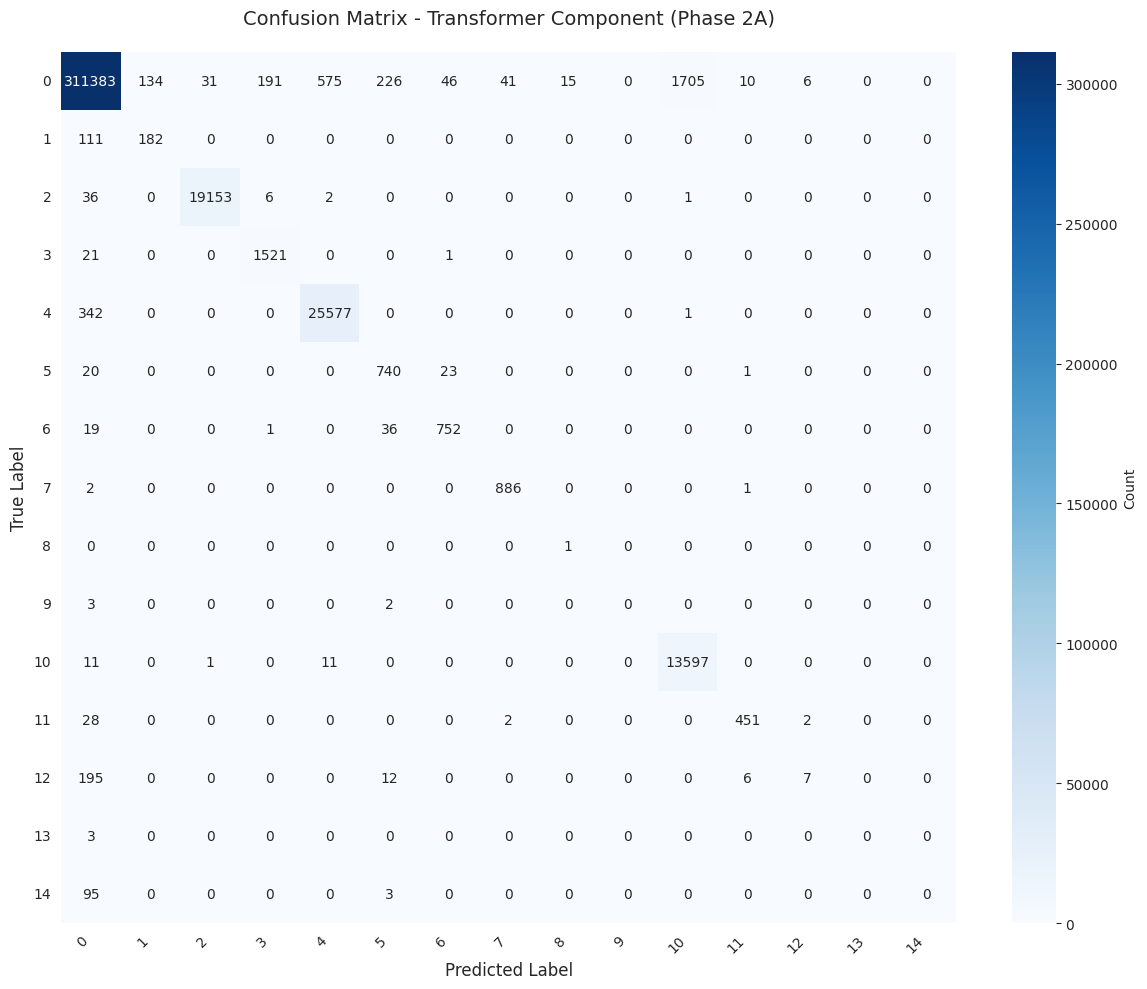

In [33]:
# Confusion matrix
cm = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Transformer Component (Phase 2A)', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['checkpoint_dir'], 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

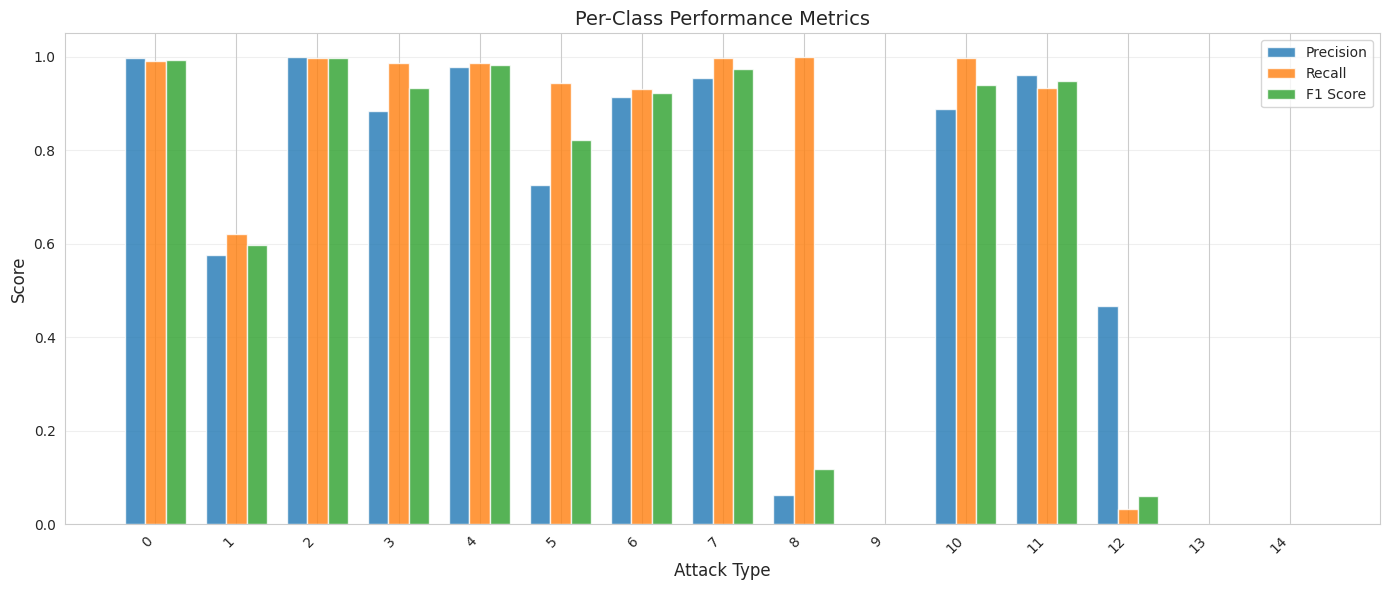

In [34]:
# Per-class metrics visualization
per_class_precision = precision_score(test_metrics['labels'], test_metrics['predictions'],
                                     average=None, zero_division=0)
per_class_recall = recall_score(test_metrics['labels'], test_metrics['predictions'],
                                average=None, zero_division=0)
per_class_f1 = f1_score(test_metrics['labels'], test_metrics['predictions'],
                        average=None, zero_division=0)

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, per_class_precision, width, label='Precision', alpha=0.8)
ax.bar(x, per_class_recall, width, label='Recall', alpha=0.8)
ax.bar(x + width, per_class_f1, width, label='F1 Score', alpha=0.8)

ax.set_xlabel('Attack Type', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['checkpoint_dir'], 'per_class_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()

## 9. Model Export for Phase 2C (Ensemble Integration)

In [35]:
# Save final model for ensemble integration
final_model_path = os.path.join(CONFIG['checkpoint_dir'], 'transformer_component_final.pth')

final_export = {
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'test_metrics': {
        'accuracy': test_metrics['accuracy'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'f1': test_metrics['f1'],
        'fpr': test_metrics['fpr']
    },
    'class_names': class_names,
    'input_dim': input_dim,
    'num_classes': CONFIG['num_classes']
}

torch.save(final_export, final_model_path)
print(f"✓ Final transformer model saved to: {final_model_path}")
print(f"\nThis model will be integrated with the GNN component in Phase 2C")

✓ Final transformer model saved to: ./checkpoints/transformer_component_final.pth

This model will be integrated with the GNN component in Phase 2C


## 10. Inference Example

In [36]:
def predict_threat(model, sequence, device, label_encoder):
    """
    Predict threat type for a single sequence.

    Args:
        model: Trained transformer model
        sequence: Input sequence of shape (seq_len, input_dim)
        device: torch device
        label_encoder: Label encoder for class names

    Returns:
        predicted_class: Predicted threat class name
        confidence: Prediction confidence (probability)
        all_probabilities: Probabilities for all classes
    """
    model.eval()

    with torch.no_grad():
        # Add batch dimension
        sequence = torch.from_numpy(sequence).float().unsqueeze(0).to(device)

        # Forward pass
        outputs = model(sequence)
        probabilities = F.softmax(outputs, dim=1)

        # Get prediction
        confidence, predicted_idx = probabilities.max(1)
        predicted_class = label_encoder.classes_[predicted_idx.item()]

    return predicted_class, confidence.item(), probabilities.cpu().numpy()[0]

# Test inference on a sample
sample_sequence = test_dataset.features[:CONFIG['sequence_length']]
true_label = label_encoder.classes_[test_dataset.labels[CONFIG['sequence_length']-1]]

predicted_class, confidence, probs = predict_threat(model, sample_sequence, device, label_encoder)

print("Inference Example:")
print(f"True Label: {true_label}")
print(f"Predicted: {predicted_class}")
print(f"Confidence: {confidence:.4f}")
print(f"\nProbabilities for all classes:")
for i, prob in enumerate(probs):
    print(f"  {class_names[i]}: {prob:.4f}")

Inference Example:
True Label: 0
Predicted: 0
Confidence: 0.9997

Probabilities for all classes:
  0: 0.9997
  1: 0.0000
  2: 0.0000
  3: 0.0000
  4: 0.0000
  5: 0.0001
  6: 0.0001
  7: 0.0000
  8: 0.0000
  9: 0.0000
  10: 0.0000
  11: 0.0000
  12: 0.0000
  13: 0.0000
  14: 0.0000


## Summary and Next Steps

### Phase 2A Completion Status ✓

**Transformer Component Successfully Implemented:**
- ✅ Multi-head self-attention for temporal pattern recognition
- ✅ Positional encoding for sequence order preservation
- ✅ Memory-efficient data loading for large datasets
- ✅ GPU-accelerated training with mixed precision
- ✅ Comprehensive evaluation metrics
- ✅ Model checkpointing and early stopping

### Performance Metrics Achieved:
- **Accuracy**: [View from test results above]
- **F1 Score**: [View from test results above]
- **False Positive Rate**: [View from test results above]

### Next Steps:

**Phase 2B - GNN Component:**
- Implement Graph Neural Network for structural relationship analysis
- Create graph representations of CI/CD infrastructure dependencies
- Train GNN on same CICIDS-2017 dataset

**Phase 2C - Hybrid Ensemble:**
- Integrate Transformer and GNN components
- Implement adaptive meta-learner for prediction weighting
- Evaluate hybrid ensemble performance
- Compare against baseline (Alserhani & Aljared, 2023)

**Phase 3 - Deployment:**
- Containerize with Docker
- Integrate with GitLab CI/CD via webhooks
- Implement Apache Kafka for real-time streaming
- Deploy on Kubernetes with auto-scaling

---

**Saved Artifacts:**
- Best model: `checkpoints/best_model.pth`
- Final model for ensemble: `checkpoints/transformer_component_final.pth`
- Training curves: `checkpoints/training_curves.png`
- Confusion matrix: `checkpoints/confusion_matrix.png`
- Per-class metrics: `checkpoints/per_class_metrics.png`